In [21]:
import numpy as np
import keras as K

import glob
import os
import PIL
import pydicom

import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_glob = 'dicom-images-train/*/*/*.dcm'
test_glob = 'dicom-images-test/*/*/*.dcm'
train_fns = sorted(glob.glob(train_glob))
test_fns = sorted(glob.glob(test_glob))

In [4]:
train_fns[0]

'dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm'

In [32]:
os.path.splitext(train_fns[0])[0].split("/")[-1]

'1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027'

In [15]:
ds.shape

(1024, 1024)

In [19]:
rle_csv = "train-rle.csv"


,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [90]:
df[df.index == "1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312"].values.shape[0]

4

In [134]:
class DataGenerator(K.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, im_path, rle_csv, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.im_paths = sorted(glob.glob(im_path))
        
        self.im_path = im_path
        self.mask_df = pd.read_csv(rle_csv, index_col='ImageId') 
        
        self.height = 1024
        self.width = 1024

        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.im_paths))]

        # Find list of IDs
        list_IDs_im = [self.im_paths[k] for k in indexes]

        # Generate data
        X, y, num_masks = self.data_generation(list_IDs_im)

        return X, y, num_masks
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def rle2mask(self, rle):
        
        mask= np.zeros(self.width * self.height)
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

        return mask.reshape(self.width, self.height).T  # Because mask is rotated

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = np.empty((len(list_IDs_im), self.height, self.width, 1))
        y = np.empty((len(list_IDs_im), self.height, self.width, 1))
        num_masks_array = np.zeros(len(list_IDs_im))

        # Generate data
        for idx, im_path in enumerate(list_IDs_im):
            
            im = pydicom.dcmread(im_path).pixel_array
            X[idx, :, :, 0] = (im - np.mean(im)) / np.std(im)
            
            img_name = os.path.splitext(im_path)[0].split("/")[-1]
            
            num_masks = self.mask_df[self.mask_df .index == img_name].values.shape[0]
            
            num_masks_array[idx] = num_masks
            
            if num_masks > 1:
                
                y[idx, :, :, 0] = np.zeros((self.height, self.width))
                for msk_idx in range(num_masks):
                    rle_string = self.mask_df[self.mask_df .index == img_name].values[msk_idx][0]
                    y[idx, :, :, 0] += self.rle2mask(rle_string)
                
            else:
                
                rle_string = self.mask_df[self.mask_df .index == img_name].values[0][0]

                if rle_string == " -1" or rle_string == " -1":
                    y[idx, :, :, 0] = np.zeros((self.height, self.width))
                    
                    num_masks_array[idx] = 0
                else:
                    y[idx, :, :, 0] = self.rle2mask(rle_string)
                    
            
        y[y>1] = 1
        
        return X,y,num_masks_array

# Train Set Images with Masks

In [135]:
a = DataGenerator(im_path='dicom-images-train/*/*/*.dcm', rle_csv="train-rle.csv", batch_size=64,shuffle=False)
images,masks,num_masks = a.__getitem__(1)


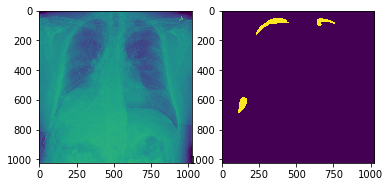

In [137]:
idx = 1

plt.subplot(1,2,1)

plt.imshow(images[idx,:,:,0])

plt.subplot(1,2,2)
plt.imshow(masks[idx,:,:,0])